# Active Learning Meetup

Autor: Luiz Matias

29 de outubro de 2020

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from modAL.uncertainty import uncertainty_sampling
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
import __init__
from src.preprocessing_functions import clean_text

In [748]:
categories = ['rec.sport.baseball', 'rec.sport.hockey', 'rec.motorcycles'] 
twenty_train = fetch_20newsgroups(subset= 'train', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

In [749]:
twenty_train.target_names

['rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

In [750]:
train_data = pd.DataFrame(twenty_train.data, columns=['Text'])
train_data['target'] = twenty_train.target
test_data = pd.DataFrame(twenty_test.data, columns=['Text'])
test_data['target'] = twenty_test.target

In [751]:
train_data['text_clean'] = list(map(clean_text, train_data['Text'].fillna('')))
test_data['text_clean'] = list(map(clean_text, test_data['Text'].fillna('')))

In [752]:
train_data.head()

,Text,target,text_clean
0,"Posted for a friend:\n\nLooking for tires, dim...",0,posted friend looking tires dimensions also lo...
1,\na lot of batters lean in when pitches come. ...,1,lot batters lean pitches come rickey crouch te...
2,"\nI tell you, Steve Stone is like a prophet.\n...",1,tell steve stone like prophet must making ton ...
3,\nTheir phone number is 1-800-377-9777. The la...,1,phone number last catalog shows three oaks jer...
4,"\n\nAnd some comments, with some players delet...",1,comments players deleted yep kevin mitchell ne...


In [753]:
train_data =  train_data[(train_data['text_clean'] != '') & (train_data['text_clean'] != ' ')].reset_index(drop=True)
test_data =  test_data[(test_data['text_clean'] != '') & (test_data['text_clean'] != ' ')].reset_index(drop=True)

In [754]:
train_data.target.value_counts()

2    584
0    583
1    572
Name: target, dtype: int64

In [755]:
df_base, df_pool = train_test_split(train_data, test_size= 0.90)

In [756]:
df_base.target.value_counts()

0    62
2    60
1    51
Name: target, dtype: int64

In [757]:
df_pool.target.value_counts()

2    524
1    521
0    521
Name: target, dtype: int64

In [758]:
tf_idf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())
])

In [794]:
X_base_sparse = tf_idf.fit_transform(df_base.text_clean)

In [795]:
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42,  algorithm='arpack')
data = svd.fit_transform(X_base_sparse) 

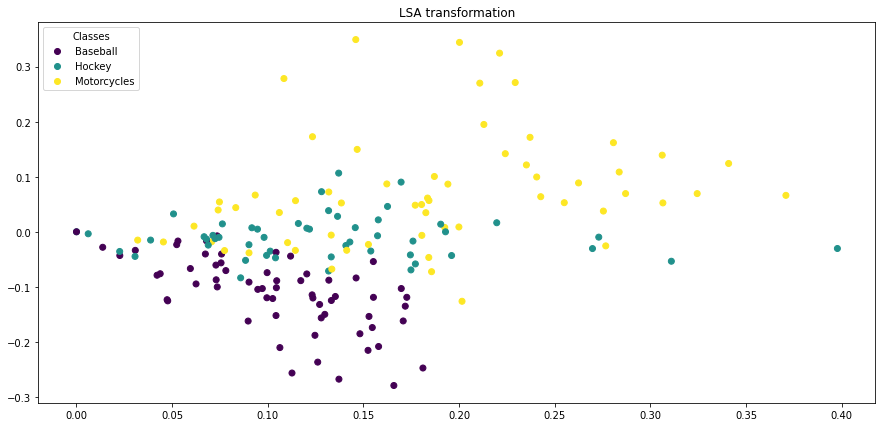

In [796]:
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c=df_base.target, cmap='viridis')
classes = ['Baseball', 'Hockey', 'Motorcycles']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

In [762]:
model = Pipeline(steps=[
    ('tfidf', TfidfVectorizer()),
    ('SVM', SVC(probability=True, random_state=42))
])

In [763]:
svm = SVC(probability=True, random_state=42)

In [764]:
X_base = df_base.text_clean
y_base = df_base.target

In [765]:
X_test = test_data.text_clean
y_test = test_data.target

In [766]:
model.fit(X_base, y_base)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SVM', SVC(probability=True, random_state=42))])

In [767]:
first_accuracy = np.round(model.score(X_test, y_test), 4)
first_accuracy

0.6646

In [768]:
X_list_base = []
y_list_base = []
X_list_base += df_base.text_clean.tolist()
y_list_base += df_base.target.tolist()

**modAL.uncertainty.uncertainty_sampling()**

Estratégia de consulta de amostragem de incerteza. Seleciona as instâncias menos seguras para rotulagem.

**Parameters**:	

**classifier** – O classificador

**X** – A amostra de pool para ser rotulada

**n_instances** – Quantas instâncias para serem rotuladas

**Retorna:**	

Os índices das instâncias de X escolhidas para serem rotuladas; as instâncias de X escolhidas para serem rotuladas.

source: https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html

In [789]:
# 4 amostras de 20 instâncias  para serem rotuladas 
N_AMOSTRAS = 35 
N_INSTANCES = 5
performance_history_active = [first_accuracy]

df_pool_active = df_pool.copy().reset_index(drop=True)

X_list_active = X_list_base.copy()
y_list_active = y_list_base.copy()

for index in range(N_AMOSTRAS):
    
    model_active = clone(model)
    model_active.fit(X_list_active, y_list_active)
    
    new_index, new_text = uncertainty_sampling(model_active, df_pool_active.text_clean, n_instances=N_INSTANCES)
        
    X_list_active += new_text.tolist()
    y_list_active += df_pool_active.loc[new_index].target.tolist()
    
    df_pool_active.drop(new_index, inplace=True)
    df_pool_active.reset_index(drop=True, inplace=True)
    
    model_acc = clone(model)
    model_acc.fit(X_list_active, y_list_active)
    score_test = model_acc.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=(index + 1) * N_INSTANCES, acc=score_test))
    performance_history_active.append(score_test)

Accuracy after query 5: 0.6568
Accuracy after query 10: 0.6473
Accuracy after query 15: 0.6360
Accuracy after query 20: 0.6820
Accuracy after query 25: 0.6716
Accuracy after query 30: 0.6941
Accuracy after query 35: 0.6759
Accuracy after query 40: 0.6802
Accuracy after query 45: 0.6828
Accuracy after query 50: 0.6846
Accuracy after query 55: 0.7461
Accuracy after query 60: 0.8206
Accuracy after query 65: 0.8206
Accuracy after query 70: 0.8198
Accuracy after query 75: 0.8189
Accuracy after query 80: 0.8111
Accuracy after query 85: 0.8206
Accuracy after query 90: 0.8024
Accuracy after query 95: 0.8033
Accuracy after query 100: 0.7920
Accuracy after query 105: 0.8224
Accuracy after query 110: 0.8215
Accuracy after query 115: 0.7764
Accuracy after query 120: 0.8250
Accuracy after query 125: 0.8267
Accuracy after query 130: 0.8293
Accuracy after query 135: 0.8423
Accuracy after query 140: 0.8302
Accuracy after query 145: 0.8094
Accuracy after query 150: 0.8024
Accuracy after query 155: 0.82

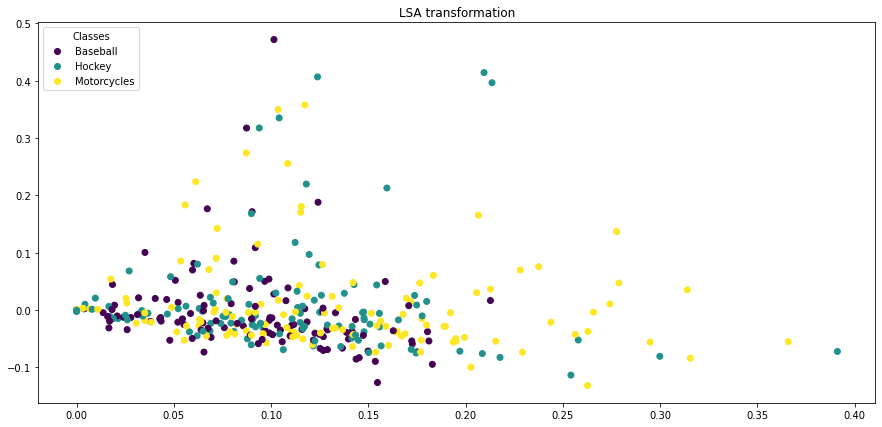

In [797]:
X_sparse = tf_idf.fit_transform(X_list_active)
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42)
data = svd.fit_transform(X_sparse) 
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c=y_list_active, cmap='viridis')
classes =  ['Baseball', 'Hockey', 'Motorcycles']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

In [791]:
# 4 amostras de 20 instâncias  para serem rotuladas 
N_AMOSTRAS = 35 
N_INSTANCES = 5
performance_history_random = [first_accuracy]

df_pool_random = df_pool.copy().reset_index(drop=True)

X_list_random = X_list_base.copy()
y_list_random = y_list_base.copy()

for index in range(N_AMOSTRAS):
    np.random.seed(0)
       
    new_index = list(np.random.randint(low=0, high=df_pool_random.shape[0], size= N_INSTANCES))
    new_text = df_pool_random.loc[new_index].text_clean
    X_list_random += new_text.tolist()
    y_list_random += df_pool_random.loc[new_index].target.tolist()
    
    df_pool_random.drop(new_index, inplace=True)
    df_pool_random.reset_index(drop=True, inplace=True)
    
    model_acc = clone(model, safe=True)
    model_acc.fit(X_list_random, y_list_random)
    score_test = model_acc.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=(index + 1) * N_INSTANCES, acc=score_test))
    performance_history_random.append(score_test)

Accuracy after query 5: 0.6750
Accuracy after query 10: 0.6880
Accuracy after query 15: 0.7028
Accuracy after query 20: 0.6898
Accuracy after query 25: 0.7314
Accuracy after query 30: 0.7574
Accuracy after query 35: 0.7470
Accuracy after query 40: 0.7166
Accuracy after query 45: 0.7088
Accuracy after query 50: 0.6967
Accuracy after query 55: 0.6889
Accuracy after query 60: 0.7080
Accuracy after query 65: 0.7149
Accuracy after query 70: 0.6993
Accuracy after query 75: 0.7262
Accuracy after query 80: 0.7288
Accuracy after query 85: 0.7600
Accuracy after query 90: 0.7340
Accuracy after query 95: 0.7175
Accuracy after query 100: 0.7288
Accuracy after query 105: 0.7409
Accuracy after query 110: 0.7574
Accuracy after query 115: 0.7522
Accuracy after query 120: 0.7366
Accuracy after query 125: 0.7201
Accuracy after query 130: 0.7296
Accuracy after query 135: 0.7348
Accuracy after query 140: 0.7114
Accuracy after query 145: 0.7582
Accuracy after query 150: 0.7608
Accuracy after query 155: 0.75

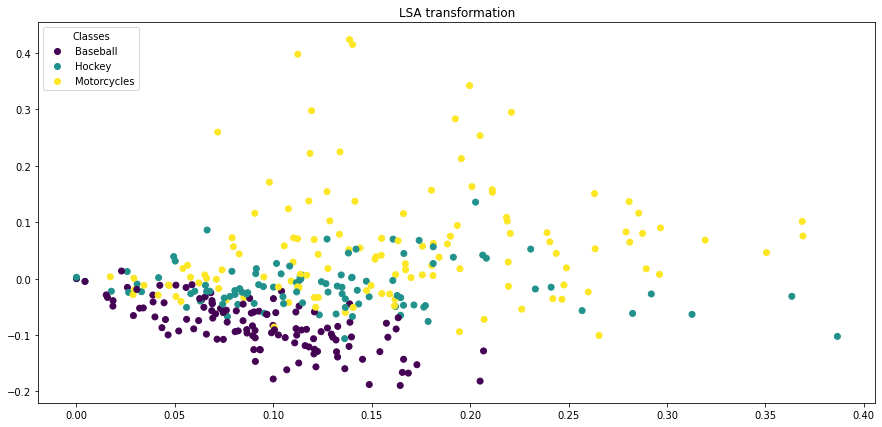

In [798]:
X_sparse = tf_idf.fit_transform(X_list_random)
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42)
data = svd.fit_transform(X_sparse) 
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c= y_list_random, cmap='viridis')
classes =  ['Baseball', 'Hockey', 'Motorcycles']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

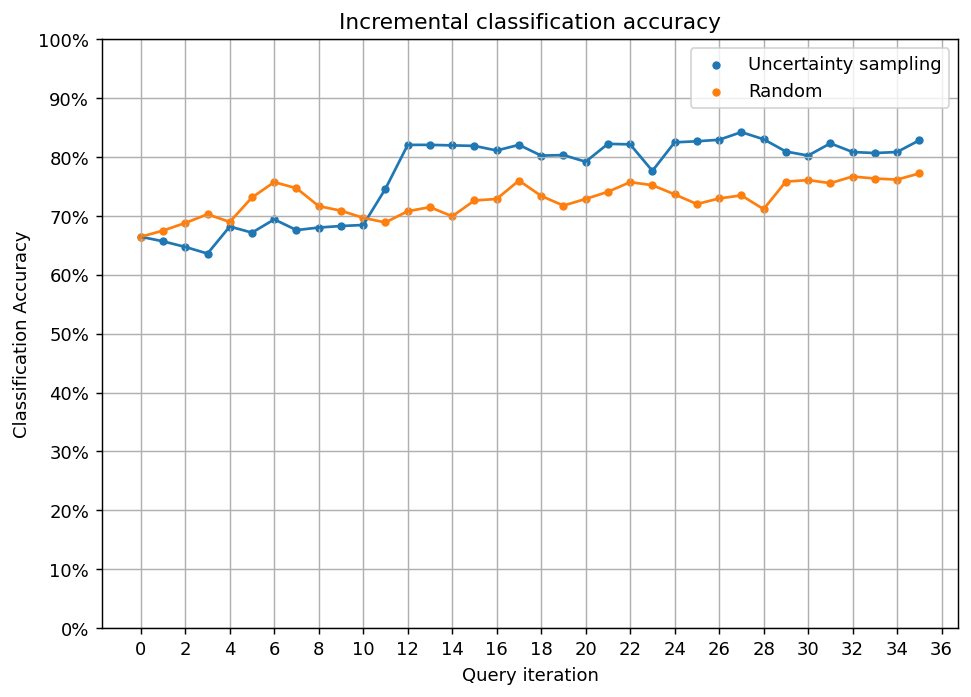

In [793]:
from src.plot_functions import  plot_performance
plot_performance(performance_history_random, performance_history_active)